# Import Google Drive

In [1]:
#from google.colab import drive
#drive.mount('/content/drive', force_remount=True)

In [2]:
#!unzip "/content/drive/MyDrive/paris.zip" -d "/content/drive/MyDrive/Paris120x120/"  > /dev/null

# Carica DataSet

In [1]:
import load_dataset
user="Andrea"

load_dataset.set_user(user)
groundtruth_dir, dataset_dir = load_dataset.get_dirs()

groundtruth_dir:  D:\Andrea\Downloads\gzp 
dataset_dir:  D:\Andrea\Downloads\Paris120x120


In [2]:
class_names = load_dataset.get_classnames()
num_classes = len(class_names)

dataset = load_dataset.get_dataset(groundtruth_dir, dataset_dir, class_names)

Numero di good:  0
Numero di ok:  1790
Numero di bad:  0
Numero di junk:  1619


Funzioni per la stampa di statistiche sul DB

In [3]:
import print_functions as prt

prt.print_dataset_stats(dataset)

Numero immagini del dataset:  2692
Numero di immagini nei vari landmark:  [225. 129. 266. 248. 344.  90. 205. 319. 147. 279. 440.]
Immagini good-ok-bad-junk:  [0, 1499, 0, 1193]
Per ogni landmark, quanti sono quelli good, ok, bad e junk: [[0, 117, 0, 108], [0, 61, 0, 68], [0, 182, 0, 84], [0, 130, 0, 118], [0, 236, 0, 108], [0, 72, 0, 18], [0, 113, 0, 92], [0, 127, 0, 192], [0, 52, 0, 95], [0, 144, 0, 135], [0, 265, 0, 175]]


In [4]:
#prt.print_class_good_images(dataset,0) #stampa tutte le immagini good della classe 0

# Split dei dati in training, validation, test set

In [5]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow import keras
import random

Dataset Shuffle

In [6]:
load_dataset.shuffle(dataset)

Dataset Split

In [7]:
# Da Dataset -> A X_train, X_val, X_test

# per avere uno split equilibrato, esso avverrà secondo il seguente criterio:
# il training set sarà formato, per ogni landmark, dall' 80% del totale delle
# good per quel landmark + 80% del totale delle ok per quel landmark + ecc...
# il test set e il validation set avranno il 10% a testa

def split_dataset(dataset, x_train, x_val, x_test):

  for i in range(len(dataset)):
    for j in range(len(dataset[i])): 
      
      num_samples = len(dataset[i][j])

      train_len = round(0.8 * num_samples)
      x_train[i][j] = x_train[i][j] + dataset[i][j][:train_len]
      
      val_len = (num_samples - train_len) // 2
      x_val[i][j] = x_val[i][j] + dataset[i][j][train_len: train_len + val_len]

      test_len = (num_samples - train_len - val_len)
      x_test[i][j] = x_test[i][j] + dataset[i][j][-test_len:]

  return;

x_train = [ [[],[],[],[]] for x in range(len(class_names))]
x_val = [ [[],[],[],[]] for x in range(len(class_names))]
x_test = [ [[],[],[],[]] for x in range(len(class_names))]

split_dataset(dataset, x_train, x_val, x_test)

x_train_len = prt.dataset_len(x_train)
x_val_len = prt.dataset_len(x_val)

print(prt.dataset_len(x_train))
print(prt.dataset_len(x_val))
print(prt.dataset_len(x_test))

2154
264
274


# Data Augmentation

Definizione degli ImageDataGenerator. Gli oggetti ImageDataGenerator definiscono le trasformazioni che si faranno.
Chiamando flow(numpy_array_immagini) su ImageDataGenerator, flow restituirà un generatore di immagini transformate.

In [8]:
#oggetto ImageDataGenerator, definisce le trasformazioni
gen_settings = keras.preprocessing.image.ImageDataGenerator(
    rotation_range=60,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=False,  
    vertical_flip=False,                     
    rescale=None,
    fill_mode='nearest'
)

#ImageDataGenerator senza trasformazioni per validation set
test_val_settings = keras.preprocessing.image.ImageDataGenerator()

Ora definiamo una classe custom che prende gli ImageDataGenerator del nostro dataset, e gli usa per creare un generatore di triplette.

In [9]:
class CustomDataGenerator(object):
    
    # parametro nel costruttore: dataset_generators. Ha la solita struttura [ [[good],[ok],[bad],[junk]],  [...], ...]
    # però invece che avere le foto nei good, ok, ... ho un generatore per quella categoria che genera le trasformazioni
    
    def __init__(self, dataset_generators,batch_size) -> None:
        self.dataset_generators = dataset_generators
        self.batch_size=batch_size

    def next_train(self):
        current_class = -1
        while 1:
            anchors=[]
            positives=[]
            negatives=[]
            for i in range(self.batch_size):
                current_class = current_class+1
                current_class = current_class % num_classes
                
                _anchor,_positive,_negative=retrieve_single_triplet(self,current_class)
                anchors.append(_anchor)
                positives.append(_positive)
                negatives.append(_negative)
            
            anchors=tf.convert_to_tensor(anchors)
            positives=tf.convert_to_tensor(positives)
            negatives=tf.convert_to_tensor(negatives)

            triplet = (anchors, positives, negatives)
            yield(triplet)
        
def retrieve_single_triplet(self,current_class):
    different_class = random.randint(0, num_classes-1)
    
    while(different_class == current_class):
        different_class = random.randint(0, num_classes-1)  
            
    _anchor = next(self.dataset_generators[current_class][1])[0]
    _positive = next(self.dataset_generators[current_class][1])[0]
    _negative = next(self.dataset_generators[different_class][random.choice([1,3])])[0]    
    return _anchor,_positive,_negative

x_train, x_val, x_test sono strutture dati di immagini così disposte: [ [[good],[ok],[bad],[junk]],  [...], ...]
Sostituiamo le immagini coi generatori creati a partire da quelle immagini.

In [10]:
import numpy as np

#x_train, x_val, x_test prima contenevano array di immagini. Ora contengono generatori separati per classe e qualità
def transform_dataset(db, gen_settings):
    ds = [ [[],[],[],[]] for x in range(len(class_names))]
    for i in range(len(ds)):
        for j in [1,3]: #abbiamo solo immagini ok e junk (1 e 3) nel database
            generatore = gen_settings.flow(x=np.asarray(db[i][j]), batch_size=1) #batch size 1 per ritornare una sola img
            ds[i][j] = generatore
    return ds

x_train_gen = transform_dataset(x_train, gen_settings)
x_val_gen = transform_dataset(x_val, test_val_settings)
#x_test = transform_dataset(x_test, test_val_settings)

In [11]:
batch_size=128
#Training generator
custom_gen_train = CustomDataGenerator(x_train_gen,batch_size)
generatore_triplete_train = custom_gen_train.next_train()

#Validation generator
custom_gen_val = CustomDataGenerator(x_val_gen,batch_size)
generatore_triplete_val = custom_gen_val.next_train() 

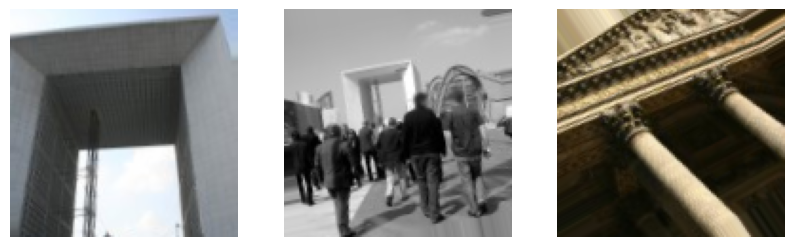

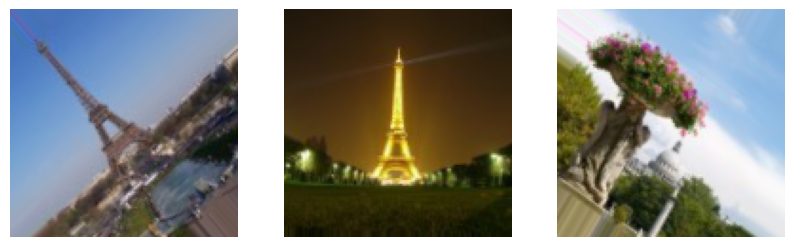

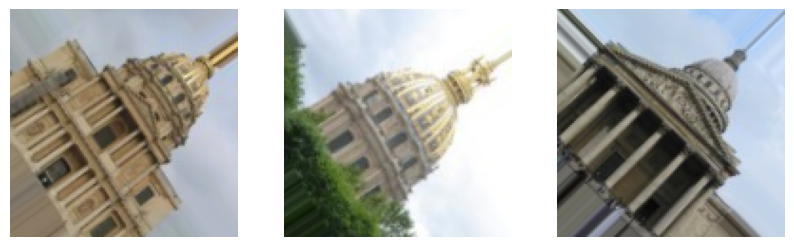

In [12]:
triplete_batch = next(generatore_triplete_train)

ancore = triplete_batch[0]
positivi = triplete_batch[1]
negativi = triplete_batch[2]

tripla1 = (ancore[0], positivi[0], negativi[0])
tripla2 = (ancore[1], positivi[1], negativi[1])
tripla3 = (ancore[2], positivi[2], negativi[2])

prt.stampa_tripletta(tripla1)
prt.stampa_tripletta(tripla2)
prt.stampa_tripletta(tripla3)

# Definizione Modello Triple

In [13]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.applications import resnet
from tensorflow.keras.applications.resnet import preprocess_input
#from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2

In [14]:
def get_encoder (input_shape):
    
    
    #base_cnn = resnet.ResNet50(
    #weights="imagenet", input_shape=input_shape, include_top=False)
    base_cnn = resnet.ResNet101(
        weights="imagenet", input_shape=input_shape, include_top=False)
    
    trainable = False
    for layer in base_cnn.layers:
        if layer.name == "conv5_block1_out":
            trainable = True
        layer.trainable = trainable
        
    encode_model = tf.keras.models.Sequential([
        base_cnn,
        layers.Flatten(),
        layers.Dense(512, activation="relu"),
        layers.BatchNormalization(),
        layers.Dense(256, activation="relu"),
        layers.BatchNormalization(),
        layers.Dense(32)
    ], name="Embedding")
    
    
    return encode_model

In [15]:
class DistanceLayer(layers.Layer):
    """
    This layer is responsible for computing the distance between the anchor
    embedding and the positive embedding, and the anchor embedding and the
    negative embedding.
    """

    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, anchor, positive, negative):
        ap_distance = tf.reduce_sum(tf.square(anchor - positive), -1)
        an_distance = tf.reduce_sum(tf.square(anchor - negative), -1)
        return (ap_distance, an_distance)

In [16]:
def get_siamese_network (input_shape = (120,120,3)):
    embedding_model = get_encoder(input_shape)
    input_anchor = tf.keras.layers.Input(shape= input_shape)
    input_positive = tf.keras.layers.Input(shape= input_shape)
    input_negative = tf.keras.layers.Input(shape= input_shape)
    
    embedding_anchor = embedding_model(resnet.preprocess_input(input_anchor))
    embedding_positive = embedding_model(resnet.preprocess_input(input_positive))
    embedding_negative = embedding_model(resnet.preprocess_input(input_negative))

    #embedding_anchor = embedding_model(input_anchor)
    #embedding_positive = embedding_model(input_positive)
    #embedding_negative = embedding_model(input_negative)

    distances = DistanceLayer()(
    embedding_anchor ,
    embedding_positive,
    embedding_negative ,
    )

    siamese_network =  tf.keras.models.Model(
    inputs=[input_anchor, input_positive, input_negative], outputs=distances
    )
    return siamese_network
    
siamese_network = get_siamese_network()  

In [17]:
class SiameseModel(tf.keras.models.Model):
    """The Siamese Network model with a custom training and testing loops.

    Computes the triplet loss using the three embeddings produced by the
    Siamese Network.

    The triplet loss is defined as:
       L(A, P, N) = max(‖f(A) - f(P)‖² - ‖f(A) - f(N)‖² + margin, 0)
    """

    def __init__(self, siamese_network, margin=0.5):
        super().__init__()
        self.siamese_network = siamese_network
        self.margin = margin
        self.loss_tracker = tf.keras.metrics.Mean(name="loss")
        self.acc_tracker =tf.keras.metrics.BinaryAccuracy(name ="accuracy")

    def call(self, inputs):
        return self.siamese_network(inputs)

    def train_step(self, data):
        # GradientTape is a context manager that records every operation that
        # you do inside. We are using it here to compute the loss so we can get
        # the gradients and apply them using the optimizer specified in
        # `compile()`.
        
        with tf.GradientTape() as tape:
            loss,acc = self._compute_loss(data)
        # Storing the gradients of the loss function with respect to the
        # weights/parameters.
        gradients = tape.gradient(loss, self.siamese_network.trainable_weights)
        # Applying the gradients on the model using the specified optimizer
        self.optimizer.apply_gradients(
            zip(gradients, self.siamese_network.trainable_weights)
        )
        # Let's update and return the training loss metric.
        self.loss_tracker.update_state(loss)
        self.acc_tracker.update_state((acc|True),acc)
        return {"loss": self.loss_tracker.result(),"acc": self.acc_tracker.result()}

    def test_step(self, data):
        
        loss,acc = self._compute_loss(data)

        # Let's update and return the loss metric.
        self.loss_tracker.update_state(loss)
        self.acc_tracker.update_state((acc|True),acc)
        return {"loss": self.loss_tracker.result(),"acc": self.acc_tracker.result()}

    def _compute_loss(self, data):
        # The output of the network is a tuple containing the distances
        # between the anchor and the positive example, and the anchor and
        # the negative example.
        ap_distance, an_distance = self.siamese_network(data)

        # Computing the Triplet Loss by subtracting both distances and
        # making sure we don't get a negative value.
        loss = ap_distance - an_distance
        loss = tf.maximum(loss + self.margin, 0.0)
        return loss, (ap_distance<an_distance)
    @property
    def metrics(self):
        # We need to list our metrics here so the `reset_states()` can be
        # called automatically.
        return [self.loss_tracker,self.acc_tracker]

In [18]:
siamese_model = SiameseModel(siamese_network)
siamese_model.compile(optimizer=tf.keras.optimizers.Adam(0.00011), weighted_metrics=[])

In [20]:
# siccome uso un generator, la dimensione del dataset diventa potenzialmente infinita
# devo definire a quanti batch corrisponde un'epoca -> steps per epoch, validation steps
steps_train=int( x_train_len/batch_size )
steps_val=int(x_val_len/batch_size)

history = siamese_model.fit(
    generatore_triplete_train,
    steps_per_epoch=steps_train,
    batch_size=batch_size,
    epochs=30,
    verbose=1,
    validation_data=generatore_triplete_val,
    validation_steps=steps_val,
    
)


Epoch 1/30
16/16 [==============================] - 159s 9s/step - loss: 0.4411 - acc: 0.6114 - val_loss: 0.4092 - val_acc: 0.6719
Epoch 2/30
16/16 [==============================] - 126s 8s/step - loss: 0.4314 - acc: 0.6239 - val_loss: 0.4057 - val_acc: 0.6680
Epoch 3/30
16/16 [==============================] - 124s 8s/step - loss: 0.4172 - acc: 0.6321 - val_loss: 0.4167 - val_acc: 0.6367
Epoch 4/30
16/16 [==============================] - 124s 8s/step - loss: 0.3935 - acc: 0.6572 - val_loss: 0.3680 - val_acc: 0.6953
Epoch 5/30
16/16 [==============================] - 123s 8s/step - loss: 0.3887 - acc: 0.6579 - val_loss: 0.3550 - val_acc: 0.6875
Epoch 6/30
16/16 [==============================] - 123s 8s/step - loss: 0.3883 - acc: 0.6544 - val_loss: 0.3714 - val_acc: 0.6562
Epoch 7/30
16/16 [==============================] - 122s 8s/step - loss: 0.3763 - acc: 0.6621 - val_loss: 0.3899 - val_acc: 0.6719
Epoch 8/30
16/16 [==============================] - 122s 8s/step - loss: 0.3750 - a

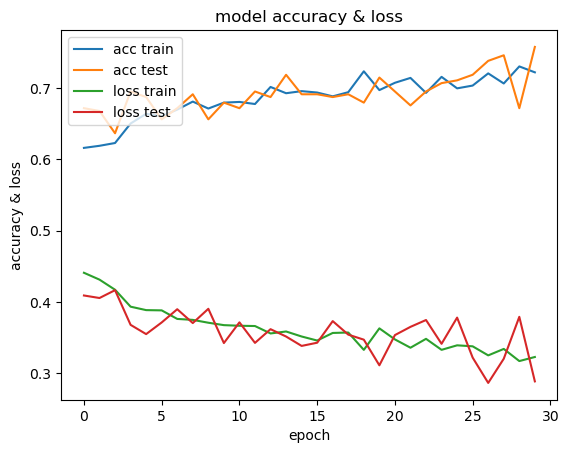

In [21]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model accuracy & loss')
plt.ylabel('accuracy & loss')
plt.xlabel('epoch')
plt.legend(['acc train', 'acc test', 'loss train','loss test'], loc='upper left')
plt.show()

# Usare il modello allenato

Runnare questa cella solo se non si ha il modello "encoder" salvato

In [22]:
def exctract_embedding(model):
    encoder=get_encoder((120,120,3))
    i=0
    for e_layer in model.layers[0].layers[9].layers:
        layer_weight= e_layer.get_weights()
        encoder.layers[i].set_weights(layer_weight)
        i+=1
    return encoder
encoder=exctract_embedding(siamese_model)
encoder.save_weights("InceptionResNetV2_lr2")
encoder.summary()

Model: "Embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet101 (Functional)      (None, 4, 4, 2048)        42658176  
                                                                 
 flatten_1 (Flatten)         (None, 32768)             0         
                                                                 
 dense_3 (Dense)             (None, 512)               16777728  
                                                                 
 batch_normalization_2 (Batc  (None, 512)              2048      
 hNormalization)                                                 
                                                                 
 dense_4 (Dense)             (None, 256)               131328    
                                                                 
 batch_normalization_3 (Batc  (None, 256)              1024      
 hNormalization)                                         

Runnare questa cella solo se si sono già calcolati i pesi per il modello "encoder"

In [23]:
#encoder=get_encoder((120,120,3))
#encoder.load_weights("encoder_generatore")

Data un immagine in ingresso, trovare quale immagine appartenente al training set sia la più vicina, e classificare l'immagine in base al graound truth dell'immagine più simile

In [24]:
#Calcolo per ogni immagine del training set l'output attraverso l'encode
def makeX_Y_array (array):
    arr=[] #ci mettiamo tutte le immagini di training good e ok
    y_train= [] #contiene le label (le classi) delle immagini in arr
    y_levels=[] #mi dice, per ogni classe, qual è il suo ultimo indice in arr
    
    previous=0
    for index in range(len(class_names)): #per ogni classe...
        arr.extend(array[index][0]) #prendo le immagini good della classe index, e le appendo in arr
        arr.extend(array[index][1]) #prendo le immagini ok della classe index, e le appendo in arr
        totLen=len(array[index][0])+len(array[index][1])
        
        k= np.zeros(len(class_names))
        k[index]=1.0
        for i in range(totLen):
            y_train.append(k)
            
        y_levels.append(previous+totLen)
        previous=y_levels[index] # y_levels indica il valore più alto appartenente alla classe indicata da index
        print(y_levels)
        
    dt= tf.data.Dataset.from_tensor_slices(arr)
    y_train = tf.data.Dataset.from_tensor_slices (y_train)
    #dt=dt.batch(32,drop_remainder=False)
    #y_train=y_train.batch(32,drop_remainder=False)
    dt=dt.batch(1,drop_remainder=False)
    y_train=y_train.batch(1,drop_remainder=False)
    return dt, y_train,y_levels

In [25]:
dt,y_train,y_levels = makeX_Y_array(x_train)

[94]
[94, 143]
[94, 143, 289]
[94, 143, 289, 393]
[94, 143, 289, 393, 582]
[94, 143, 289, 393, 582, 640]
[94, 143, 289, 393, 582, 640, 730]
[94, 143, 289, 393, 582, 640, 730, 832]
[94, 143, 289, 393, 582, 640, 730, 832, 874]
[94, 143, 289, 393, 582, 640, 730, 832, 874, 989]
[94, 143, 289, 393, 582, 640, 730, 832, 874, 989, 1201]


In [26]:
points=encoder.predict(dt) #prendo il training set, e con predict ottengo per ogni foto una sua "codifica" (points)
#points: (1201,32)

In [27]:
from math import*
from decimal import Decimal
  
def classify_images(tensor):
    distance = tf.reduce_sum(tf.square(points - tensor), -1)
    return distance

def retrieve_mean_distance(tensor):
    distance = []  
    for index in range(len(class_names)):
        if index==0:
            diClasse=tensor[0:y_levels[index]]
        else:
            diClasse=tensor[y_levels[index-1]:y_levels[index]]
          
        distance.append( tf.math.reduce_min(diClasse) )  # per ritrovare la media basta mettere reduce_mean/min
        #distance.append( tf.math.reduce_mean(diClasse) )
    
    #toRet= tf.reduce_min(distance) 
    #distribution = tf.math.equal(distance,toRet)
    #distribution = tf.cast(distribution,tf.float32)
    distribution = tf.nn.softmax(distance)
    distribution =tf.subtract(distribution,1)
    distribution = tf.negative(distribution)
    distribution= tf.divide(distribution,len(distribution)-1)
    return distribution #l'indice della classe con la distanza media minore

class DistanceClassificationLayer(layers.Layer):
    """
    This layer is responsible for computing the distance between the anchor
    embedding and the positive embedding, and the anchor embedding and the
    negative embedding.
    """

    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.points=points #sarebbe il training set "codificato" dall'encoder

    def call(self, tensor): #tensor di dimensione (1,32), input del layer e encoding di un immagine di test set        
        #per ogni immagine vado a calcolare la distanza rispetto a tutte le foto del training set
        predicts = tf.map_fn(classify_images,tensor) #predicst: (1,1201)
        #print("\n",tf.shape(predicts))
        
        #PER USARE LA MEDIA INVECE CHE IL MINIMO SCOMMENTRARE QUESTI 2 E COMMENTARE I 2 SUCCESSIVI
        test = tf.map_fn(retrieve_mean_distance,predicts)
        return test
    
        #predicts=tf.argmin(predicts,-1) #prendo l'indice dell'immagine rispetto al training set con la distanza minore
        #return retrieve_label(predicts) # ritrovo dall'indice la classe
    
       
evaluation_model=tf.keras.models.Sequential([encoder,DistanceClassificationLayer()])

Vado a creare un dataset dove (x_test, classi associata)

In [28]:
evaluate_dt,res,re_levels= makeX_Y_array(x_test)
evaluate_dt= tf.data.Dataset.zip((evaluate_dt,res))

[12]
[12, 18]
[12, 18, 36]
[12, 18, 36, 49]
[12, 18, 36, 49, 73]
[12, 18, 36, 49, 73, 80]
[12, 18, 36, 49, 73, 80, 92]
[12, 18, 36, 49, 73, 80, 92, 105]
[12, 18, 36, 49, 73, 80, 92, 105, 110]
[12, 18, 36, 49, 73, 80, 92, 105, 110, 125]
[12, 18, 36, 49, 73, 80, 92, 105, 110, 125, 152]


In [46]:
evaluation_model.compile(metrics=[tf.keras.metrics.TopKCategoricalAccuracy(k=2)])
evaluation_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Embedding (Sequential)      (None, 32)                59578528  
                                                                 
 distance_classification_lay  (None, 11)               0         
 er (DistanceClassificationL                                     
 ayer)                                                           
                                                                 
Total params: 59,578,528
Trainable params: 25,850,144
Non-trainable params: 33,728,384
_________________________________________________________________


In [47]:
evaluation = evaluation_model.evaluate(evaluate_dt)

152/152 [==============================] - 8s 38ms/step - loss: 0.0000e+00 - top_k_categorical_accuracy: 0.5921


In [42]:
#print(res)
#print(len(evaluate_dt), len(evaluate_dt[0]), len(evaluate_dt[0][0]), len(evaluate_dt[0][0][0]))

In [43]:
test_coding=encoder.predict(evaluate_dt) 

TOP K Artigianale fatto a mano

In [33]:
def get_max_index(v):
    m = 0
    index = -1
    for i in range(len(v)):
        if v[i] > m:
            index = i
            m = v[i]
    return index

predizioni = []
for i in range(len(test_coding)):
    distances = tf.reduce_sum(tf.square(points - test_coding[i]), -1)
    
    x = []  
    for index in range(len(class_names)):
        if index==0:
            diClasse=distances[0:y_levels[index]]
        else:
            diClasse=distances[y_levels[index-1]:y_levels[index]]
        x.append( tf.math.reduce_min(diClasse) )
    distribution = tf.nn.softmax(x)
    distribution =tf.subtract(distribution,1)
    distribution = tf.negative(distribution)
    distribution= tf.divide(distribution,len(distribution)-1)
    #print(predizioni, "\n")
    predizioni.append(distribution.numpy().tolist())#(get_max_index(distribution))
    #print(predizioni, "\n")
print(np.shape(predizioni))

puppa = [[0 for i in range(len(predizioni[0]))] for i in range(len(class_names))]



o = 0
for i in range(len(predizioni)):
    if re_levels[o]-1 < i:
        o = o+1
    index = 0
    m = predizioni[i][0]
    for j in range(len(predizioni[i])):
        if predizioni[i][j] > m:
            m = predizioni[i][j]
            index = j
    puppa[o][index] = puppa[o][index] + 1
        
for i in range(len(class_names)):
    print(puppa[i])
    #[12, 18, 36, 49, 73, 80, 92, 105, 110, 125, 152]
#for i in range(len(puppa)):
#    print(puppa[i])

(152, 11)
[2, 1, 2, 4, 0, 0, 1, 0, 0, 1, 1]
[1, 1, 1, 0, 2, 0, 0, 0, 0, 0, 1]
[2, 1, 7, 0, 1, 0, 0, 2, 2, 2, 1]
[1, 1, 4, 5, 1, 1, 0, 0, 0, 0, 0]
[3, 0, 1, 0, 9, 1, 2, 1, 3, 2, 2]
[0, 0, 2, 0, 0, 5, 0, 0, 0, 0, 0]
[1, 0, 3, 0, 0, 0, 7, 0, 0, 0, 1]
[0, 0, 1, 1, 2, 0, 1, 5, 0, 1, 2]
[0, 0, 0, 0, 0, 0, 1, 0, 4, 0, 0]
[1, 0, 4, 1, 1, 0, 1, 0, 0, 6, 1]
[1, 2, 2, 1, 1, 0, 0, 1, 1, 2, 16]


In [62]:
def v(re_levels):
    res = [[0 for i in range(len(class_names))] for i in range(len(predizioni))]
    j = 0
    for i in range(len(predizioni)):
        res[i][j] = 1
        if i>=re_levels[j]-1:
            j=j+1
    #for i in range(len(predizioni)):
        #print(res[i])
    return res

a = v(re_levels)
b = predizioni

a = a[:]
b = b[:]

#print(a)
#print(b)

m1 = tf.keras.metrics.TopKCategoricalAccuracy(k=4)
m1.update_state(a,#v(re_levels),
                b)#predizioni)
m1.result().numpy()

0.78289473